# Retrieval Agent

A notebook to explain how the retrieval Agent works

In [1]:
from contextlib import contextmanager
from dataclasses import dataclass, field
from typing import (Generator, Annotated, Any, Literal, Optional, Sequence,
                    Union)
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from langchain_core.embeddings import Embeddings
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

In [2]:
VECTORSTORE_DIR = "../src/user_data/vectorstore/"

In [3]:
embeddings = OllamaEmbeddings(model="nomic-embed-text", num_ctx=4096) 
# Context window size, default 2048 seems to trigger "decode: cannot decode
# batches with this context (use llama_encode() instead)" in Ollama

In [4]:
# Found in src/core/retrieval.py

_COLLECTION = "HOMER"
_COLLECTION_METADATA = {"hnsw:space": "cosine"}

vector_store = Chroma(
  collection_name = _COLLECTION,
  collection_metadata= _COLLECTION_METADATA,
  embedding_function = embeddings,
  persist_directory = VECTORSTORE_DIR,  # Where to save data locally
)

retriever = vector_store.as_retriever(
  )

In [5]:
def context_search(query: str) -> str:
    """
    This function sends a request to a knowledge base and returns the
    k closest chunks of text.
    Args:
        - query : the request (str)
    Returns:
        - context : the retrieved documents (str)
    """
    
    docs=retriever.invoke(input=query)
    from ..src.utils.utils import format_docs
    context = format_docs(docs=docs)
    return context

tools = [context_search]

In [6]:
model = ChatOllama(model="qwen3:0.6b",
                   temperature=0,
                   #num_ctx=8192
).bind_tools(tools)

In [7]:
# Found in src/core/retrieval.py

_COLLECTION = "HOMER"
_COLLECTION_METADATA = {"hnsw:space": "cosine"}

vector_store = Chroma(
  collection_name = _COLLECTION,
  collection_metadata= _COLLECTION_METADATA,
  embedding_function = embeddings,
  persist_directory = VECTORSTORE_DIR,  # Where to save data locally
)

retriever = vector_store.as_retriever()

## States

The state will be passed down each nodes and updated. The input state can be different from the output state.

In [8]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

## Nodes

### Tool node
The tool node is a function called "context_search" which will perform a 
search in a chromaDB vectorstore. It will be called by the main model node.

In [9]:
SYSTEM_PROMPT = """You are Homer, an AI assistant that helps users find
information in their personal knowledge base. You have access to a tool called
'context_search' which allows you to search for relevant documents based on a
user's query. Use this tool to retrieve the most relevant information to answer
the user's questions accurately and comprehensively.
"""

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    messages = state["messages"]+[]    
    response = model.invoke(messages)
    return {"messages": response}

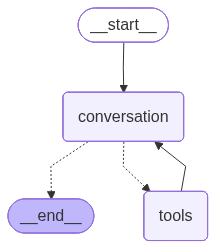

In [11]:
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "conversation")
workflow.add_edge("conversation", END)

# Compile
#memory = MemorySaver()
#graph = workflow.compile(checkpointer=memory)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
input = {
    "messages":[HumanMessage(content="Hello World!")]
}
for message_chunk, metadata in graph.stream(
    input=input,
    stream_mode="conversation", # Stream the "messages" value of the graph state
):
    print(message_chunk.content,flush=True)